In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math as math

from shapely.geometry import Point
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import chi2

In [4]:
df = pd.read_csv('ACRA_w_SO.csv')

# Drop rows where Coordinate_X or Coordinate_Y is -1
df = df[(df['Coordinate_X'] != -1) & (df['Coordinate_Y'] != -1)]

# Initialise new dataframe for data we want to analyse
df_analysis = pd.DataFrame()
df_analysis['uen'] = df['uen']
df_analysis['Sector'] = df['Sector']
df_analysis['status'] = df['status']

# Convert the 5 struck off dates to datetime
date_cols = [f'Struck Off Date {i}' for i in range(1, 6)]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# Calculate the average date for each firm
df_analysis['Exit Date'] = df[date_cols].mean(axis=1)

# Convert Entry Date to datetime
df_analysis['Entry Date'] = df['registration_incorporation_date']
df_analysis['Entry Date'] = pd.to_datetime(df_analysis['Entry Date'])

In [5]:
# Read the geojson file
regions = gpd.read_file('region_boundary.geojson')
regions = regions.to_crs("EPSG:3414") # Convert to Singapore CRS

# Map the region names to the corresponding codes
region_map = {
    'kml_1': 'WR',
    'kml_2': 'NR',
    'kml_3': 'NER',
    'kml_4': 'ER',
    'kml_5': 'CR'
}
regions['Name'] = regions['Name'].map(region_map)

# Create a GeoDataFrame from the df DataFrame
geometry = [Point(xy) for xy in zip(df['Coordinate_X'], df['Coordinate_Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3414")

# Spatial join: assign each firm the region it falls into
gdf_with_region = gpd.sjoin(gdf, regions, how='left', predicate='within')

# Update df_analysis with the mapped region assignments
df_analysis['Region'] = gdf_with_region['Name'].values

In [6]:
df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER


Functions

In [128]:
def plot_age_distribution(df, *, year='2023', sector=None, label=None):
    """
    Plot the age distribution of firms.
    
    Parameters:
    df: DataFrame containing the firms.
    year: The year to filter the firms by.
    sector: The sector to filter the firms by (optional).
    label: Label for the plot (optional).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure 'Entry Date' and 'Exit Date' are datetime objects
    df['Entry Date'] = pd.to_datetime(df['Entry Date'])
    df['Exit Date'] = pd.to_datetime(df['Exit Date'], errors='coerce')
    # Convert year to datetime object
    date = pd.to_datetime(year + '-01-01') 

    # Filter firms alive at the given date
    df_filtered = df.copy()
    df_filtered = df[
        (df['Entry Date'] < date) &
        ((df['Exit Date'].isna()) | (df['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    # Filter by sector if provided
    if sector is not None:
        df_filtered = df_filtered[df_filtered['Sector'] == sector]
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=label
    )

def log_likelihood(mu, alive_counts, dead_counts):
    phi = 1 - mu # Say phi is the survival probability (i.e. phi = 1 - mu)
    log_p = 0
    for i in range(1, len(alive_counts)):
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi) + math.log(math.comb(alive_counts[i] + dead_counts[i], dead_counts[i]))
    return log_p

def neg_log_likelihood(params, alive_counts1, dead_counts1, alive_counts2, dead_counts2):
    mu1, mu2 = params
    ll1 = log_likelihood(mu1, alive_counts1, dead_counts1)
    ll2 = log_likelihood(mu2, alive_counts2, dead_counts2)
    return -(ll1 + ll2)  # negative for minimization

# Function to perform the likelihood ratio test
# 
def likelihood_ratio_test(df_a, df_b):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to the nearest year
    df1['Entry Date'] = df1['Entry Date'].dt.year + (df1['Entry Date'].dt.month >= 7).astype(int)
    df2['Entry Date'] = df2['Entry Date'].dt.year + (df2['Entry Date'].dt.month >= 7).astype(int)

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # Calculate the MLE for H0
    mu_mle = minimize_scalar(
        lambda mu: -log_likelihood(mu, alive_counts_1, dead_counts_1) - log_likelihood(mu, alive_counts_2, dead_counts_2),
        bounds=(0.01, 0.99),
        method='bounded'
    ).x

    # Calculate the log-likelihood for H0
    ll_h0 = log_likelihood(mu_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_mle, alive_counts_2, dead_counts_2)

    # Calculate the MLE for H1
    result = minimize(
        neg_log_likelihood,
        x0=[0.1, 0.1],  # initial guess for mu1 and mu2
        args=(alive_counts_1, dead_counts_1, alive_counts_2, dead_counts_2),
        bounds=[(0.01, 0.99), (0.01, 0.99)]
    )
    mu_1_mle, mu_2_mle = result.x

    # Calculate the log-likelihood for H1
    ll_h1 = log_likelihood(mu_1_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_2_mle, alive_counts_2, dead_counts_2)

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=1)

    return lrt_statistic, p_value, mu_mle, mu_1_mle, mu_2_mle

# Create filtered dataframes
def filter_dataframe(category, filter, *, category2 = None, filter2 = None):
    """
    Filter the df_analysis dataframe based on the given category and filter.
    If category2 and filter2 are provided, it will filter based on both conditions.
    """
    if category2 is not None and filter2 is not None:
        df = df_analysis.copy()
        df = df[(df[category] == filter) & (df[category2] == filter2)]
    else:
        df = df_analysis.copy()
        df = df[df[category] == filter]
        
    return df

def plot_survival_fractions(df, label):
    """
    Plot survival fractions against age.
    """

    # Create list of ages from 0 to 60
    ages_sf = np.arange(0, 61, 1)
    # Create list of 31 years from 1963 to 2023
    years = np.arange(1963, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to nearest year
    df['Entry Date'] = df['Entry Date'].dt.year + (df['Entry Date'].dt.month >= 7).astype(int)

    # Create list of alive/dead firms for each year
    alive_counts = []
    dead_counts = []
    for year in years:
        alive_count = df[
            (df['Entry Date'] == year) &
            (df['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

        dead_count = df[
            (df['Entry Date'] == year) &
            (df['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages_sf, survival_fractions, label=label, marker='o', markersize=3)

def plot_log_survival_fractions(df, label):
    """
    Plot survival fractions against age.
    """

    # Create list of ages from 0 to 30
    ages_sf = np.arange(0, 31, 1)
    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to nearest year
    df['Entry Date'] = df['Entry Date'].dt.year + (df['Entry Date'].dt.month >= 7).astype(int)

    # Create list of alive/dead firms for each year
    alive_counts = []
    dead_counts = []
    for year in years:
        alive_count = df[
            (df['Entry Date'] == year) &
            (df['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

        dead_count = df[
            (df['Entry Date'] == year) &
            (df['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages_sf, np.log(survival_fractions), label=label, marker='o', markersize=3)

    log_survival = np.log(survival_fractions)

    # Fit linear model (least squares)
    coeffs = np.polyfit(ages_sf, log_survival, deg=1)
    predicted = np.polyval(coeffs, ages_sf)
    plt.plot(ages_sf, predicted, label=f'Linear Fit ({label})', linestyle='--')

    # Compute R^2
    ss_res = np.sum((log_survival - predicted)**2)
    ss_tot = np.sum((log_survival - np.mean(log_survival))**2)

    r_squared = 1 - (ss_res / ss_tot)
    print(f"R²: {r_squared}")


def plot_exponential(mu, *, label='Exponential Fit', linestyle='--'):
    """
    Plot the exponential survival function S(age) = exp(-mu * age).
    """
    ages = np.arange(0, 61, 1)
    survival_fractions = np.exp(-mu * ages)
    plt.plot(ages, survival_fractions, label=label, linestyle=linestyle)

Likelihood ratio tests, first chunk without sampling and second chunk with sampling

Sample size for df_a: 316135
Sample size for df_b: 519007
Likelihood Ratio Test Statistic: 7.919660268700682
P-value for the likelihood ratio test: 0.004890045399743667
MLE for mu: 0.10655952239133479
MLE for mu_a: 0.10591756506628687 and MLE for mu_b: 0.106929665994572
Reject H0: Death rates are different.


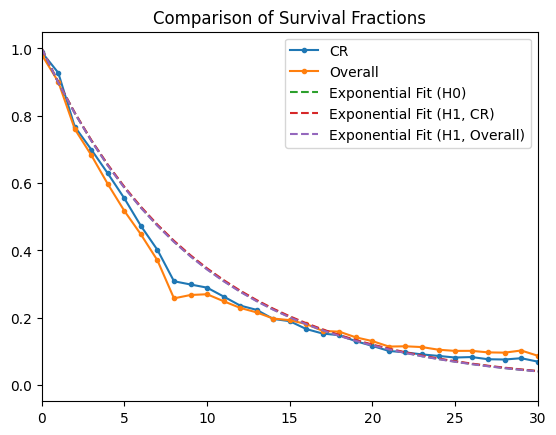

In [11]:
region_list = ['CR', 'NR', 'WR', 'ER', 'NER']
# for region1 in region_list:
region1 = 'CR'
df_a = filter_dataframe('Region', region1, category2='Sector', filter2='G')
df_b = filter_dataframe('Sector', 'G')

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = region1)
plot_survival_fractions(df_b, label = 'Overall')
# Plot the exponential survival function
plot_exponential(mu_mle, label='Exponential Fit (H0)', linestyle='--')
plot_exponential(mu_1, label='Exponential Fit (H1, CR)')
plot_exponential(mu_2, label='Exponential Fit (H1, Overall)')

plt.title('Comparison of Survival Fractions')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.legend()
plt.show()

Sample size for df_a: 111817
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 18.966457641217858
P-value for the likelihood ratio test: 1.3303674776865099e-05
MLE for mu: 0.10001483448479152
MLE for mu_a: 0.09828513043186972 and MLE for mu_b: 0.10014486848020941
Reject H0: Death rates are different.


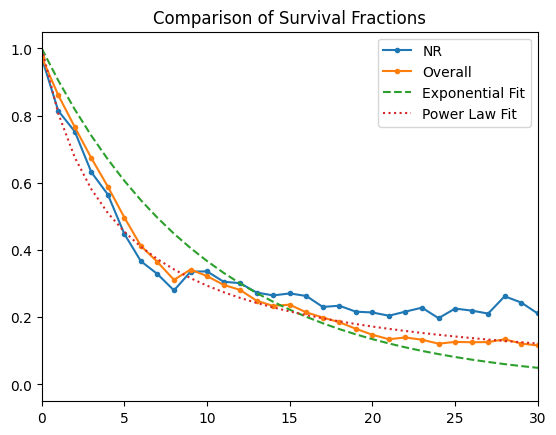

In [9]:
df_a = filter_dataframe('Region', 'NR')
df_b = df_analysis.copy()

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'NR')
plot_survival_fractions(df_b, label = 'Overall')
# Plot the exponential survival function
plot_exponential(mu_2)
# Test plot for power law fit
ages = np.arange(0, 61, 1)
plt.plot(ages,(5/(1.2*ages+5)) , label='Power Law Fit', linestyle=':')

plt.title('Comparison of Survival Fractions')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.legend()
plt.show()

Sample size for df_a: 191979
Sample size for df_b: 157204
Likelihood Ratio Test Statistic: 330.7470646831207
P-value for the likelihood ratio test: 6.6080941524439164e-74
MLE for mu: 0.09697154406036017
MLE for mu_a: 0.09333749541417231 and MLE for mu_b: 0.10180783209048766
-174761.33333512797 -174595.9598027864
Reject H0: Death rates are different.


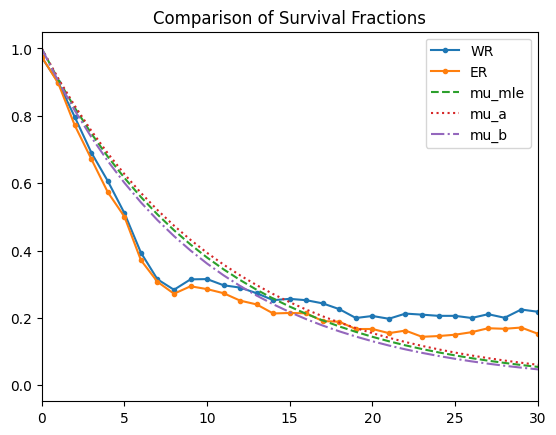

In [ ]:
df_a = filter_dataframe('Region', 'WR')
df_b = filter_dataframe('Region', 'ER')

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'WR')
plot_survival_fractions(df_b, label = 'ER')
# Plot the exponential survival function
plot_exponential(mu_mle, label='mu_mle', linestyle='--')
plot_exponential(mu_1, label='mu_a', linestyle=':')
plot_exponential(mu_2, label='mu_b', linestyle='-.')

plt.title('Comparison of Survival Fractions')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.legend()
plt.show()

Sample size for df_a: 100000
Sample size for df_b: 100000
Likelihood Ratio Test Statistic: 5.142705040081637
P-value for the likelihood ratio test: 0.02334424707951431
MLE for mu: 0.09753201054252422
MLE for mu_a: 0.09684272067317765 and MLE for mu_b: 0.09822445952387168
Reject H0: Death rates are different.


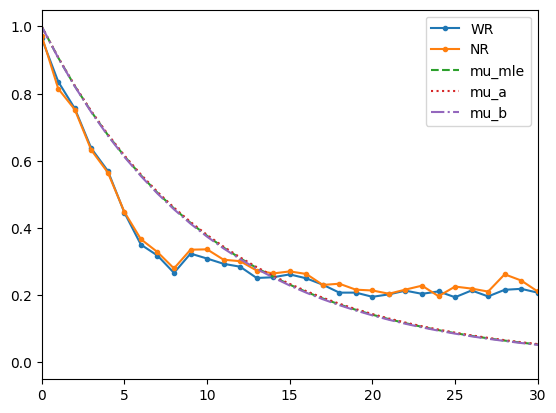

In [11]:
df_a = filter_dataframe('Region', 'WR')
df_b = filter_dataframe('Region', 'NR')

# Sample 10,000 firms from each DataFrame (with replacement if not enough rows)
df_a_sample = df_a.sample(n=100000, replace=(len(df_a) < 100000))
df_b_sample = df_b.sample(n=100000, replace=(len(df_b) < 100000))

print(f'Sample size for df_a: {len(df_a_sample)}')
print(f'Sample size for df_b: {len(df_b_sample)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a_sample, df_b_sample)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'WR')
plot_survival_fractions(df_b, label = 'NR')
# Plot the exponential survival function
plot_exponential(mu_mle, label='mu_mle', linestyle='--')
plot_exponential(mu_1, label='mu_a', linestyle=':')
plot_exponential(mu_2, label='mu_b', linestyle='-.')

plt.xlim(0, 30)
plt.legend()
plt.show()

R²: 0.9383439719218964


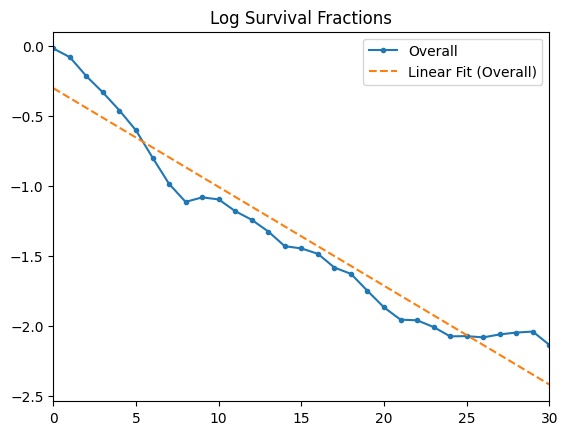

In [118]:
df_overall = df_analysis.copy()
plot_log_survival_fractions(df_overall, label='Overall')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.title('Log Survival Fractions')
plt.legend()
plt.show()


R²: 0.7533614247185819


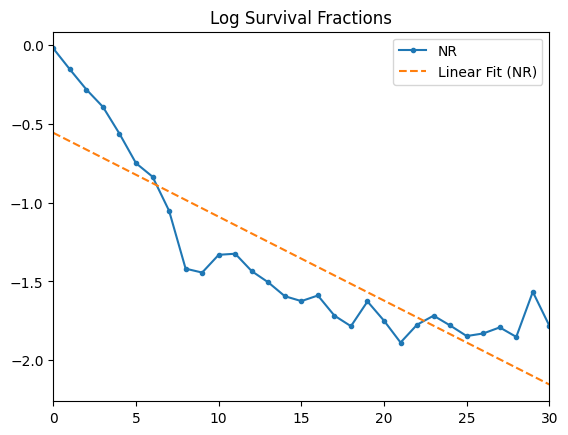

In [108]:
region = 'NR'
df_a = filter_dataframe('Region', region, category2='Sector', filter2='G')
plot_log_survival_fractions(df_a, label=region)
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.title('Log Survival Fractions')
plt.legend()
plt.show()

# Seems like F is more linear?

Non-constant death rate (age-dependent)

$\mu = \frac{\lambda}{1+\alpha t}$

In [125]:
def log_likelihood_power(params, alive_counts, dead_counts):
    log_p = 0
    a, b = params
    for i in range(1, len(alive_counts)):
        phi = 1 - a/(1+b*i) # Say phi is the survival probability (i.e. phi = 1 - mu)
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi) + math.log(math.comb(alive_counts[i] + dead_counts[i], dead_counts[i]))
    return log_p

# Function to perform the likelihood ratio test
def likelihood_ratio_test_power(df_a, df_b, *, initial=[0.1,0.01,0.1,0.01]):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to the nearest year
    df1['Entry Date'] = df1['Entry Date'].dt.year + (df1['Entry Date'].dt.month >= 7).astype(int)
    df2['Entry Date'] = df2['Entry Date'].dt.year + (df2['Entry Date'].dt.month >= 7).astype(int)

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # H0: a, b are the same for both groups
    def neg_ll_h0(params):
        return -(log_likelihood_power(params, alive_counts_1, dead_counts_1) +
                 log_likelihood_power(params, alive_counts_2, dead_counts_2))
    result_h0 = minimize(neg_ll_h0, x0=[0.1,0.01], bounds=[(1e-4, 1), (1e-4, 10)])
    a_mle, b_mle = result_h0.x
    ll_h0 = -neg_ll_h0([a_mle, b_mle])

   # H1: a, b are different for each group
    def neg_log_likelihood(params):
        a1, b1, a2, b2 = params
        ll1 = log_likelihood_power([a1, b1], alive_counts_1, dead_counts_1)
        ll2 = log_likelihood_power([a2, b2], alive_counts_2, dead_counts_2)
        return -(ll1 + ll2)  # negative for minimization
    result_h1 = minimize(
        neg_log_likelihood,
        x0=initial,
        bounds=[(1e-4, 1), (1e-4, 10), (1e-4, 1), (1e-4, 10)]
    )
    a1_mle, b1_mle, a2_mle, b2_mle = result_h1.x
    ll_h1 = -neg_log_likelihood([a1_mle, b1_mle, a2_mle, b2_mle])

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=2)

    return lrt_statistic, p_value, [a_mle, b_mle, a1_mle, b1_mle, a2_mle, b2_mle]

Likelihood Ratio Test Statistic: 90.23372135110009
P-value for the likelihood ratio test: 2.5468089524510486e-20
Under H0, MLE for a, b: 0.12247932937997315, 0.05655472968261065
Under H1, MLE for a1, b1, a2, b2: 0.1121733077754039, 0.057792435577692605, 0.14015168473697293, 0.06039531604096147


C:\Users\chong\AppData\Local\Temp\ipykernel_23992\1480393103.py:190: RuntimeWarning: invalid value encountered in divide
  survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))
C:\Users\chong\AppData\Local\Temp\ipykernel_23992\1480393103.py:190: RuntimeWarning: invalid value encountered in divide
  survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))


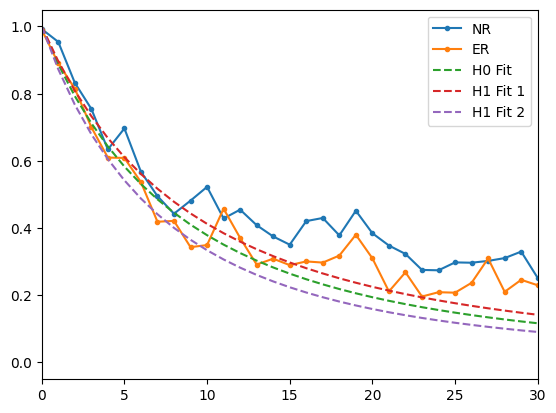

In [127]:
df_a = filter_dataframe('Region', 'NR', category2='Sector', filter2='C')
df_b = filter_dataframe('Region', 'ER', category2='Sector', filter2='C')

# Perform likelihood ratio test
lrt_statistic, p_value, params = likelihood_ratio_test_power(df_a, df_b, initial=[0.1, 0.014, 0.009, 0.06])
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'Under H0, MLE for a, b: {params[0]}, {params[1]}')  # Under H0
print(f'Under H1, MLE for a1, b1, a2, b2: {params[2]}, {params[3]}, {params[4]}, {params[5]}')  # Under H1

# Plot survival fractions against age
plot_survival_fractions(df_a, label='NR')
plot_survival_fractions(df_b, label='ER')
ages = np.arange(0, 31, 1)
plt.plot(ages, (1+params[1]*ages)**(-params[0]/params[1]), linestyle='--', label='H0 Fit')
plt.plot(ages, (1+params[3]*ages)**(-params[2]/params[3]), linestyle='--', label='H1 Fit 1')
plt.plot(ages, (1+params[5]*ages)**(-params[4]/params[5]), linestyle='--', label='H1 Fit 2')
plt.xlim(0, 30)
plt.legend()
plt.show()

a1_power = params[2]
b1_power = params[3]

Likelihood Ratio Test Statistic: 371.33387314213905
P-value for the likelihood ratio test: 2.3220628763677537e-81
Under H0, MLE for a, b: 0.14341599528679827, 0.023139889518838407
Under H1, MLE for a1, b1, a2, b2: 0.13029053553356496, 0.014890646671851842, 0.15157121528194165, 0.028484003350473304


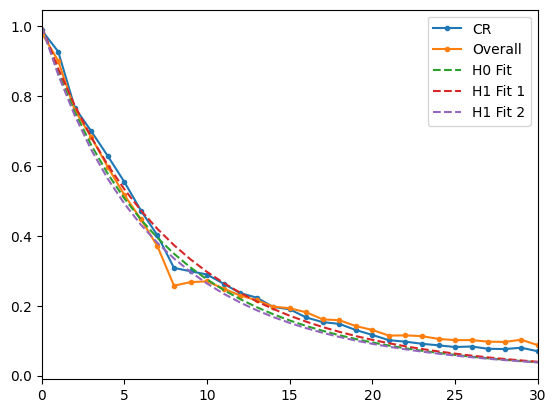

In [56]:
df_a = filter_dataframe('Region', 'CR', category2='Sector', filter2='G')
df_b = filter_dataframe('Sector', 'G')
#df_b = filter_dataframe('Region', 'NER', category2='Sector', filter2='G')

# Perform likelihood ratio test
lrt_statistic, p_value, params = likelihood_ratio_test_power(df_a, df_b, initial=[0.1, 0.15, 0.18, 0.06])
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'Under H0, MLE for a, b: {params[0]}, {params[1]}')  # Under H0
print(f'Under H1, MLE for a1, b1, a2, b2: {params[2]}, {params[3]}, {params[4]}, {params[5]}')  # Under H1

# Plot survival fractions against age
plot_survival_fractions(df_a, label='CR')
plot_survival_fractions(df_b, label='Overall')
ages = np.arange(0, 31, 1)
plt.plot(ages, (1+params[1]*ages)**(-params[0]/params[1]), linestyle='--', label='H0 Fit')
plt.plot(ages, (1+params[3]*ages)**(-params[2]/params[3]), linestyle='--', label='H1 Fit 1')
plt.plot(ages, (1+params[5]*ages)**(-params[4]/params[5]), linestyle='--', label='H1 Fit 2')
plt.xlim(0, 30)
plt.legend()
plt.show()

$\mu = \lambda e^{-\beta t}$

In [129]:
def log_likelihood_exp(params, alive_counts, dead_counts):
    log_p = 0
    a, b = params
    for i in range(1, len(alive_counts)):
        phi = 1 - a*np.exp(-b*i) # Say phi is the survival probability (i.e. phi = 1 - mu)
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi) + math.log(math.comb(alive_counts[i] + dead_counts[i], dead_counts[i]))
    return log_p

# Function to perform the likelihood ratio test
def likelihood_ratio_test_exp(df_a, df_b, *, initial=[0.1,0.01,0.1,0.01]):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to the nearest year
    df1['Entry Date'] = df1['Entry Date'].dt.year + (df1['Entry Date'].dt.month >= 7).astype(int)
    df2['Entry Date'] = df2['Entry Date'].dt.year + (df2['Entry Date'].dt.month >= 7).astype(int)

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # H0: a, b are the same for both groups
    def neg_ll_h0(params):
        return -(log_likelihood_exp(params, alive_counts_1, dead_counts_1) +
                 log_likelihood_exp(params, alive_counts_2, dead_counts_2))
    result_h0 = minimize(neg_ll_h0, x0=[0.1,0.05], bounds=[(1e-4, 1), (1e-4, 10)])
    a_mle, b_mle = result_h0.x
    ll_h0 = -result_h0.fun

   # H1: a, b are different for each group
    def neg_log_likelihood(params):
        a1, b1, a2, b2 = params
        ll1 = log_likelihood_exp([a1, b1], alive_counts_1, dead_counts_1)
        ll2 = log_likelihood_exp([a2, b2], alive_counts_2, dead_counts_2)
        return -(ll1 + ll2)  # negative for minimization
    result_h1 = minimize(
        neg_log_likelihood,
        x0=initial,
        bounds=[(1e-4, 1), (1e-4, 10), (1e-4, 1), (1e-4, 10)]
    )
    a1_mle, b1_mle, a2_mle, b2_mle = result_h1.x
    ll_h1 = -result_h1.fun

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=2)

    return lrt_statistic, p_value, [a_mle, b_mle, a1_mle, b1_mle, a2_mle, b2_mle]

Likelihood Ratio Test Statistic: 0.2275035325603767
P-value for the likelihood ratio test: 0.892479471886562
Under H0, MLE for a, b: 0.17133437486255826, 0.03500796856856582
Under H1, MLE for a1, b1, a2, b2: 0.17091966843494769, 0.03494237337234648, 0.17196014769225115, 0.03508416016187977


C:\Users\chong\AppData\Local\Temp\ipykernel_23992\370524680.py:190: RuntimeWarning: invalid value encountered in divide
  survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))


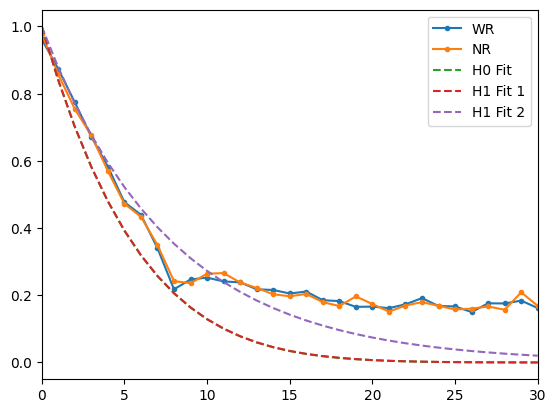

In [130]:
df_a = filter_dataframe('Region', 'WR', category2='Sector', filter2='G')
df_b = filter_dataframe('Region', 'NR', category2='Sector', filter2='G')

# Perform likelihood ratio test
lrt_statistic, p_value, params = likelihood_ratio_test_exp(df_a, df_b, initial=[0.13,0.02,0.13,0.02])
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'Under H0, MLE for a, b: {params[0]}, {params[1]}')  # Under H0
print(f'Under H1, MLE for a1, b1, a2, b2: {params[2]}, {params[3]}, {params[4]}, {params[5]}')  # Under H1

# Plot survival fractions against age
plot_survival_fractions(df_a, label='WR')
plot_survival_fractions(df_b, label='NR')
ages = np.arange(0, 31, 1)
plt.plot(ages, np.exp(-(params[0] / params[1]) * (np.exp(params[1] * ages) - 1)), linestyle='--', label='H0 Fit')
plt.plot(ages, np.exp(-(params[2] / params[3]) * (np.exp(params[3] * ages) - 1)), linestyle='--', label='H1 Fit 1')
plt.plot(ages, np.exp(-(0.13 / 0.000000001) * (np.exp(0.000000001 * ages) - 1)), linestyle='--', label='H1 Fit 2')
plt.xlim(0, 30)
plt.legend()
plt.show()

a1_exp = params[2]
b1_exp = params[3]

R²: 0.747720360133079


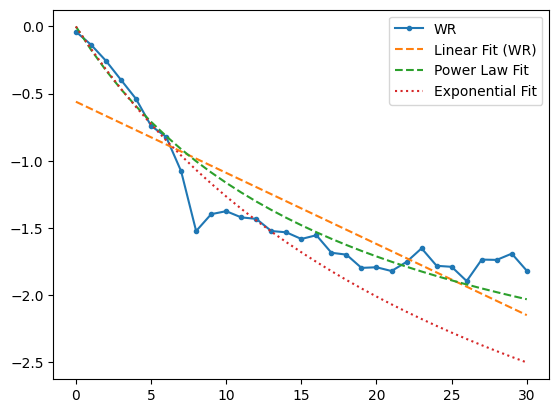

In [101]:
df_a = filter_dataframe('Region', 'WR', category2='Sector', filter2='G')
plot_log_survival_fractions(df_a, label='WR')
plt.plot(ages, -(a1_power/(1+b1_power*ages))*ages, linestyle='--', label='Power Law Fit')
plt.plot(ages, -(a1_exp/(1+b1_exp*ages))*ages, linestyle=':', label='Exponential Fit')
plt.legend()
plt.show()

$\mu = \alpha  ln(\beta x+1)$

In [98]:
def log_likelihood_ln(params, alive_counts, dead_counts):
    log_p = 0
    a, b = params
    for i in range(1, len(alive_counts)):
        phi = 1 - a * np.log(b*i+1) # Say phi is the survival probability (i.e. phi = 1 - mu)
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi)
    return log_p

# Function to perform the likelihood ratio test
def likelihood_ratio_test_ln(df_a, df_b, *, initial=[0.1,0.01,0.1,0.01]):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1993 to 2023
    years = np.arange(1993, 2024, 1)
    years = years[::-1]

    # Convert Entry Date to the nearest year
    df1['Entry Date'] = df1['Entry Date'].dt.year + (df1['Entry Date'].dt.month >= 7).astype(int)
    df2['Entry Date'] = df2['Entry Date'].dt.year + (df2['Entry Date'].dt.month >= 7).astype(int)

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # H0: a, b are the same for both groups
    def neg_ll_h0(params):
        return -(log_likelihood_power(params, alive_counts_1, dead_counts_1) +
                 log_likelihood_power(params, alive_counts_2, dead_counts_2))
    result_h0 = minimize(neg_ll_h0, x0=[0.1,0.01], bounds=[(1e-4, 1), (1e-4, 10)])
    a_mle, b_mle = result_h0.x
    ll_h0 = -neg_ll_h0([a_mle, b_mle])

   # H1: a, b are different for each group
    def neg_log_likelihood(params):
        a1, b1, a2, b2 = params
        ll1 = log_likelihood_power([a1, b1], alive_counts_1, dead_counts_1)
        ll2 = log_likelihood_power([a2, b2], alive_counts_2, dead_counts_2)
        return -(ll1 + ll2)  # negative for minimization
    result_h1 = minimize(
        neg_log_likelihood,
        x0=initial,
        bounds=[(1e-4, 1), (1e-4, 10), (1e-4, 1), (1e-4, 10)]
    )
    a1_mle, b1_mle, a2_mle, b2_mle = result_h1.x
    ll_h1 = -neg_log_likelihood([a1_mle, b1_mle, a2_mle, b2_mle])

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=2)

    return lrt_statistic, p_value, [a_mle, b_mle, a1_mle, b1_mle, a2_mle, b2_mle]

Likelihood Ratio Test Statistic: 0.6897471787233371
P-value for the likelihood ratio test: 0.7083098857135561
Under H0, MLE for a, b: 0.18238633224065134, 0.05615357155945351
Under H1, MLE for a1, b1, a2, b2: 0.18191100215149567, 0.05617165646960355, 0.18297964048891543, 0.055926529511695224


C:\Users\chong\AppData\Local\Temp\ipykernel_23992\2127043594.py:190: RuntimeWarning: invalid value encountered in divide
  survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))


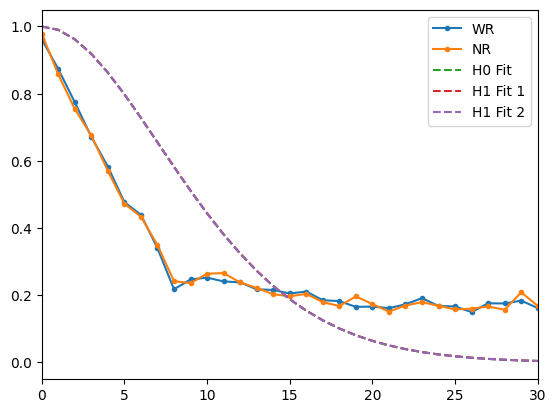

In [99]:
df_a = filter_dataframe('Region', 'WR', category2='Sector', filter2='G')
df_b = filter_dataframe('Region', 'NR', category2='Sector', filter2='G')
# Perform likelihood ratio test
lrt_statistic, p_value, params = likelihood_ratio_test_ln(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'Under H0, MLE for a, b: {params[0]}, {params[1]}')  # Under H0
print(f'Under H1, MLE for a1, b1, a2, b2: {params[2]}, {params[3]}, {params[4]}, {params[5]}')  # Under H1
# Plot survival fractions against age
plot_survival_fractions(df_a, label='WR')
plot_survival_fractions(df_b, label='NR')
ages = np.arange(0, 31, 1)
plt.plot(ages, np.exp(-(params[0] * np.log(params[1] * ages + 1))*ages), linestyle='--', label='H0 Fit')
plt.plot(ages, np.exp(-(params[2] * np.log(params[3] * ages + 1))*ages), linestyle='--', label='H1 Fit 1')
plt.plot(ages, np.exp(-(params[4] * np.log(params[5] * ages + 1))*ages), linestyle='--', label='H1 Fit 2')
plt.xlim(0, 30)
plt.legend()
plt.show()

a1_ln = params[2]
b1_ln = params[3]